In [36]:
import polars as pl

In [37]:
!python -m pip install "pymongo[srv]"


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
from pymongo import MongoClient
uri = "mongodb+srv://riverdata.mtspjxg.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority&appName=RiverData"
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='./db_cert.pem'
                    )
db = client['riverdata']
collection = db['weather-forecasts']

query_df = pl.DataFrame(collection.find({}))
query_df.head(5)

forecast_timestamp,metadata,forecast_data,_id
datetime[μs],struct[1],struct[20],object
2024-07-16 17:26:44.664,"{{54.774,-1.558}}","{[2024-07-16 17:00:00, 2024-07-16 18:00:00, … 2024-07-21 16:00:00],[0, 75, … 5],[0, 0, … 0],[0, 0, … 0],[0, 0, … null],[0.0, 0.69, … 0.0],[2.25, 0.69, … null],[0.0, 0.69, … 0.02],[0, 0, … 0],[0, 0, … null],[0, 0, … 0],[0, 0, … 0],[0, 0, … null],[0, 0, … 0],[16.88, 16.13, … 16.51],[16.88, 16.13, … 16.51],[0, 0, … null],[10.04, 6.11, … 24.14],[2.81, 4.55, … 7.53],[1.0, 2.56, … 5.48]}",6696ad54ce50a76e5d170f8c
2024-07-16 17:45:03.070,"{{54.774,-1.558}}","{[2024-07-16 17:00:00, 2024-07-16 18:00:00, … 2024-07-21 16:00:00],[0, 75, … 5],[0, 0, … 0],[0, 0, … 0],[0, 0, … null],[0.0, 6.22, … 0.0],[2.83, 7.38, … null],[0.0, 0.39, … 0.02],[0, 0, … 0],[0, 0, … null],[0, 0, … 0],[0, 0, … 0],[0, 0, … null],[0, 0, … 0],[16.88, 16.13, … 16.51],[16.88, 16.13, … 16.51],[0, 0, … null],[10.04, 6.11, … 24.14],[2.81, 4.55, … 7.53],[1.0, 2.56, … 5.48]}",6696b19f543d276f78c9994d
2024-07-16 18:00:03.029,"{{54.774,-1.558}}","{[2024-07-16 18:00:00, 2024-07-16 19:00:00, … 2024-07-21 17:00:00],[100, 50, … 5],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[3.45, 3.45, … 0.0],[3.46, 3.39, … 0.02],[3.45, 3.45, … 0.02],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[16.81, 15.83, … 16.31],[16.81, 15.83, … 16.31],[0, 0, … null],[9.13, 6.73, … 24.14],[3.0, 3.19, … 7.54],[1.19, 1.78, … 5.11]}",6696b523cc99a34f24906d35
2024-07-16 18:15:02.858,"{{54.774,-1.558}}","{[2024-07-16 18:00:00, 2024-07-16 19:00:00, … 2024-07-21 17:00:00],[20, 0, … 5],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[3.12, 1.44, … 0.0],[1.74, 0.13, … 0.02],[1.17, 0.0, … 0.02],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[16.69, 15.83, … 16.31],[16.69, 15.83, … 16.31],[0, 0, … null],[8.83, 6.73, … 24.14],[3.13, 3.19, … 7.54],[1.31, 1.78, … 5.11]}",6696b8a6de2a380ab5a5da6c
2024-07-16 18:30:02.657,"{{54.774,-1.558}}","{[2024-07-16 18:00:00, 2024-07-16 19:00:00, … 2024-07-21 17:00:00],[20, 75, … 5],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[3.12, 1.33, … 0.0],[3.13, 0.12, … 0.02],[1.17, 0.18, … 0.02],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[0, 0, … 0],[16.69, 16.08, … 16.31],[16.69, 16.08, … 16.31],[0, 0, … null],[8.83, 9.56, … 24.14],[3.13, 3.7, … 7.54],[1.31, 2.08, … 5.11]}",6696bc2abd86dc0eff30e2ba


In [68]:
df = (
    query_df.select(
        pl.col("forecast_timestamp").alias("forecast_made_timestamp"),
        pl.col("forecast_data").struct.field("time").alias("forecast_data_timestamp"),
        pl.col("forecast_data").struct.field("precipitationProbability").alias("forecast_precipitation_probability"),
        pl.col("forecast_data").struct.field("rainAccumulationLwe").alias("forecast_rain_accumulation_lwe"),
    )
    .unnest(
        "forecast_data_timestamp",
        "forecast_precipitation_probability",
        "forecast_rain_accumulation_lwe",
    )
    .explode("forecast_data")
    .with_columns(
        (
            (
                pl.col("forecast_data_timestamp") - pl.col("forecast_made_timestamp")
            ).dt.total_seconds()
            / 3600
            + 1
        )
        .floor()
        .alias("forecast_time_ahead_hrs")
    )
    .drop("forecast_made_timestamp")
)
df.head()
    

TypeError: argument 'columns': 'Expr' object cannot be converted to 'PyString'

In [47]:
from httpx import Client
from hydrology import HydrologyApi

client = Client()

api = HydrologyApi(client)

stations = pl.read_json('./stations.json')

observed = (
  api.get_measures(stations, start_date=forecast["forecast_data_time"].min())
  .select(
    pl.selectors.contains('rainfall'),
    pl.col('dateTime')
  )
)
observed.head()

North Dalton - rainfall,Knitlsey Mill - rainfall,Peterlee - rainfall,Fulwell - rainfall,Harpington Hill Farm - rainfall,dateTime
f32,f32,f32,f32,f32,datetime[μs]
0.0,0.0,0.0,0.0,0.0,2024-07-16 00:00:00
0.0,0.0,0.0,0.0,0.0,2024-07-16 00:15:00
0.0,0.0,0.0,0.0,0.0,2024-07-16 00:30:00
0.0,0.0,0.0,0.0,0.0,2024-07-16 00:45:00
0.0,0.0,0.0,0.0,0.0,2024-07-16 01:00:00


In [51]:
joined = observed.join(forecast.rename({"forecast_data_time": "dateTime"}), on="dateTime", how="inner").drop_nulls()
joined.head()

North Dalton - rainfall,Knitlsey Mill - rainfall,Peterlee - rainfall,Fulwell - rainfall,Harpington Hill Farm - rainfall,dateTime,forecast_data_precipitationProbability,forecast_data_freezingRainIntensity,forecast_data_iceAccumulation,forecast_data_iceAccumulationLwe,forecast_data_rainAccumulation,forecast_data_rainAccumulationLwe,forecast_data_rainIntensity,forecast_data_sleetAccumulation,forecast_data_sleetAccumulationLwe,forecast_data_sleetIntensity,forecast_data_snowAccumulation,forecast_data_snowAccumulationLwe,forecast_data_snowIntensity,forecast_data_temperature,forecast_data_temperatureApparent,forecast_data_uvIndex,forecast_data_visibility,forecast_data_windGust,forecast_data_windSpeed,forecast_time_ahead_hrs
f32,f32,f32,f32,f32,datetime[μs],i64,i64,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,f64,f64,f64
0.0,0.2,0.0,0.0,0.6,2024-07-16 17:00:00,0,0,0,0,0.0,2.25,0.0,0,0,0,0,0,0,16.88,16.88,0,10.04,2.81,1.0,0.0
0.0,0.0,0.2,0.2,0.0,2024-07-16 18:00:00,75,0,0,0,0.69,0.69,0.69,0,0,0,0,0,0,16.13,16.13,0,6.11,4.55,2.56,1.0
0.0,0.0,0.0,0.4,0.0,2024-07-16 19:00:00,25,0,0,0,0.7,0.12,0.23,0,0,0,0,0,0,15.83,15.83,0,6.73,3.19,1.78,2.0
0.0,0.0,0.0,0.0,0.0,2024-07-16 20:00:00,0,0,0,0,0.08,0.01,0.0,0,0,0,0,0,0,15.43,15.43,0,9.15,3.11,1.69,3.0
0.0,0.0,0.0,0.2,0.0,2024-07-16 21:00:00,5,0,0,0,0.0,0.22,0.04,0,0,0,0,0,0,15.12,15.12,0,14.08,5.28,3.01,4.0


<Axes: >

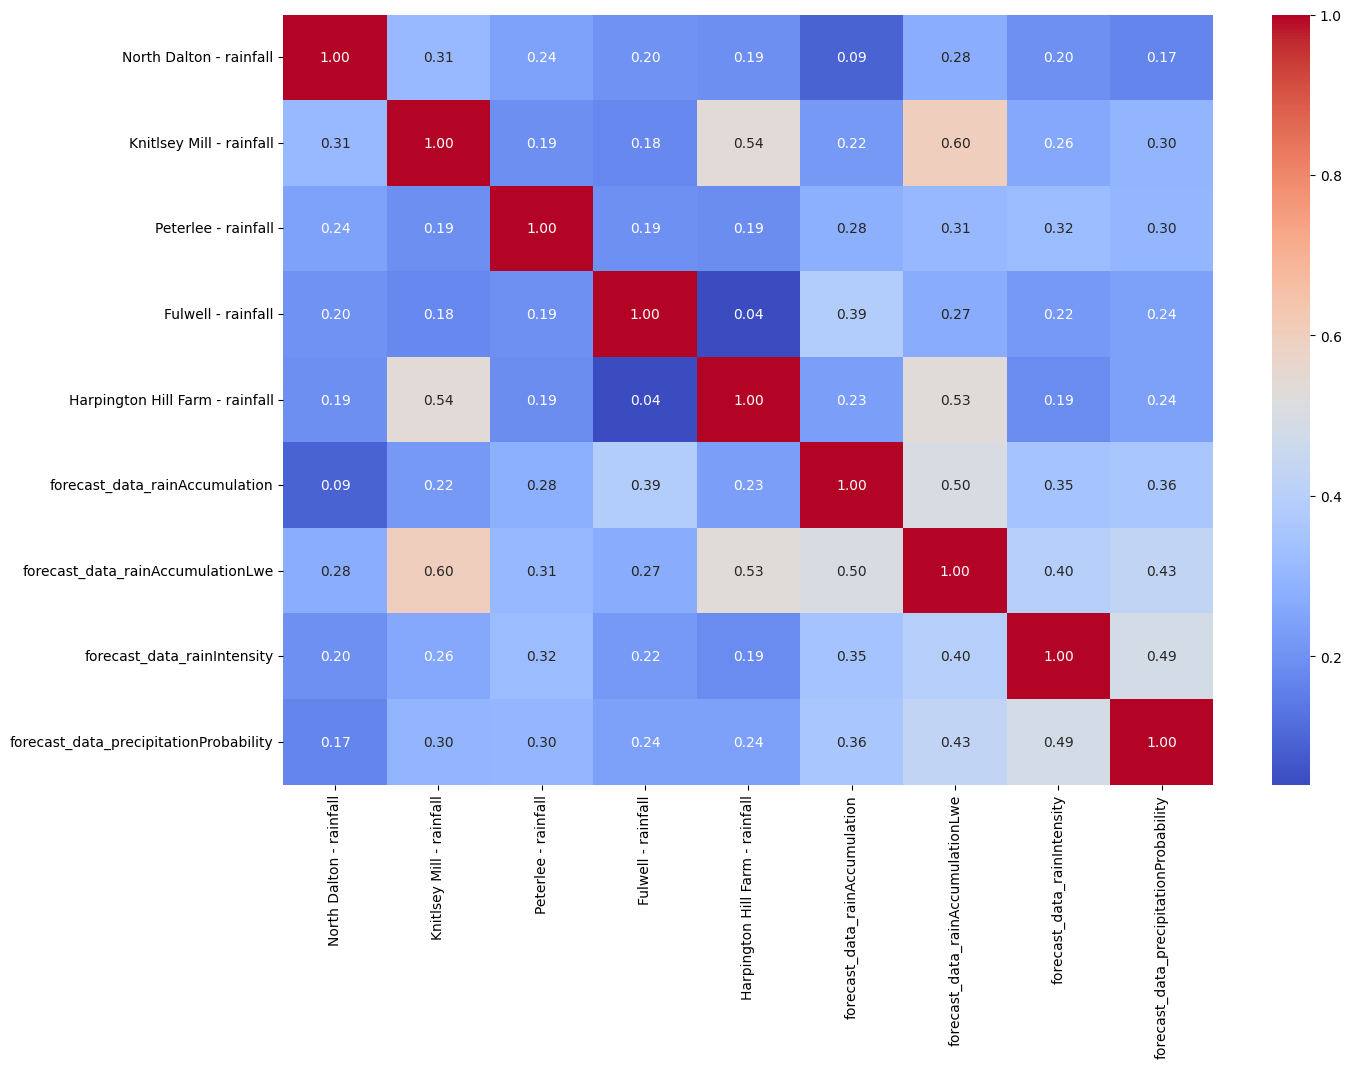

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = (
  joined
  .filter(pl.col('forecast_time_ahead_hrs') == 0)
  .select(
    pl.selectors.contains('rainfall'),
    pl.col(''),
    pl.selectors.contains('forecast_data_precipitation'),
  )
  .to_pandas()
  .corr()
)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)




In [ ]:
# Build a simple linear model from observed rainfall data to forecasted rainfall data